**notebook version**: `3` (4 Jul 2024)  
**new in this version**: added check if downloaded data is indeed in 30MIN time resolution

- This notebook can be used to download data from the database `InfluxDB`
- Data are stored to a `.csv` file in this folder

</br>

# **Auto-settings**

## Data settings

In [2]:
DIRCONF = r'F:\Sync\luhk_work\20 - CODING\22 - POET\configs'
# DIRCONF = r'P:\Flux\RDS_calculations\_scripts\_configs\configs'  # Folder with configuration files: needed e.g. for connection to database
TIMEZONE_OFFSET_TO_UTC_HOURS = 1  # Timezone, e.g. "1" is translated to timezone "UTC+01:00" (CET, winter time)
REQUIRED_TIME_RESOLUTION = '30min'  # 30MIN time resolution

## Imports

In [5]:
import importlib.metadata
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from diive.core.io.files import save_parquet

sns.set_theme('notebook')
from diive.core.plotting.timeseries import TimeSeries
from dbc_influxdb import dbcInflux
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.times.times import TimestampSanitizer
from diive.pkgs.createvar.potentialradiation import potrad
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS
from diive.core.io.files import load_parquet
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")
version_dbc = importlib.metadata.version("dbc_influxdb")
print(f"dbc-influxdb version: v{version_dbc}")
dbc = dbcInflux(dirconf=DIRCONF)  # Connect to database

diive version: v0.80.0
dbc-influxdb version: v0.12.0
Reading configuration files was successful.
Connection to database works.


</br>

# **LOAD DATA** from files

In [10]:
filename_data_simple_2005_2020 = "13.1_CH-CHA_FEIGENW_meteo_2005-2020.parquet"
data_simple_2005_2020 = load_parquet(filepath=filename_data_simple_2005_2020)
data_simple_2005_2020

Loaded .parquet file 13.1_CH-CHA_FEIGENW_meteo_2005-2020.parquet (0.045 seconds). Detected time resolution of <30 * Minutes> / 30min 


,G_GF1_0.03_1,LW_IN_T1_2_1,LW_OUT_T1_2_1,PA_GF1_0.9_1,FLAG_PA_GF1_0.9_1_ISFILLED,PPFD_IN_T1_2_2,PREC_RAIN_TOT_GF1_0.5_1,FLAG_PREC_RAIN_TOT_GF1_0.5_1_ISFILLED,RH_T1_2_1,FLAG_RH_T1_2_1_ISFILLED,SWC_GF1_0.05_1,SWC_GF1_0.15_1,SWC_GF1_0.75_1,SW_IN_T1_2_1,FLAG_SW_IN_T1_2_1_ISFILLED,SW_OUT_T1_2_1,TA_T1_2_1,FLAG_TA_T1_2_1_ISFILLED,TS_GF1_0.04_1,TS_GF1_0.15_1,TS_GF1_0.4_1
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,
2005-01-01 00:15:00,NaN,NaN,NaN,978.100000,1.0,NaN,0.0,1.0,85.400000,1.0,NaN,NaN,NaN,3.0,3.0,NaN,1.566667,3.0,NaN,NaN,NaN
2005-01-01 00:45:00,NaN,NaN,NaN,977.933333,1.0,NaN,0.0,1.0,85.700000,1.0,NaN,NaN,NaN,3.0,3.0,NaN,1.533333,3.0,NaN,NaN,NaN
2005-01-01 01:15:00,NaN,NaN,NaN,977.900000,1.0,NaN,0.1,1.0,86.600000,1.0,NaN,NaN,NaN,3.0,3.0,NaN,1.566667,3.0,NaN,NaN,NaN
2005-01-01 01:45:00,NaN,NaN,NaN,977.833333,1.0,NaN,0.0,1.0,89.600000,1.0,NaN,NaN,NaN,3.0,3.0,NaN,1.566667,3.0,NaN,NaN,NaN
2005-01-01 02:15:00,NaN,NaN,NaN,977.833333,1.0,NaN,0.1,1.0,91.433333,1.0,NaN,NaN,NaN,0.0,3.0,NaN,1.500000,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 21:45:00,-5.246918,327.0590,305.8658,958.613800,0.0,0.012177,0.0,0.0,100.000000,0.0,43.15512,37.83649,42.34799,0.0,0.0,-13.17378,-0.059646,0.0,7.059905,4.751553,5.665280
2020-12-31 22:15:00,-5.688780,325.6822,299.9425,958.361800,0.0,0.015688,0.0,0.0,100.000000,0.0,43.14826,37.83116,42.34475,0.0,0.0,-14.05419,-0.747990,0.0,7.037867,4.753286,5.666638
2020-12-31 22:45:00,-6.256253,325.8016,303.5924,958.257100,0.0,0.015338,0.0,0.0,100.000000,0.0,43.14190,37.82694,42.34330,0.0,0.0,-13.52161,-0.606677,0.0,7.021161,4.754451,5.668180


In [11]:
filename_data_simple_2021_2023 = "14.1_CH-CHA_DATABASE_meteo6_2021-2023.parquet"
data_simple_2021_2023 = load_parquet(filepath=filename_data_simple_2021_2023)
data_simple_2021_2023

Loaded .parquet file 14.1_CH-CHA_DATABASE_meteo6_2021-2023.parquet (0.006 seconds). Detected time resolution of <30 * Minutes> / 30min 


,LW_IN_T1_2_1,PA_GF1_0.9_1,PPFD_IN_T1_2_2,RH_T1_2_1,SW_IN_T1_2_1,TA_T1_2_1
TIMESTAMP_MIDDLE,,,,,,
2021-01-01 00:15:00,332.179450,958.107523,0.0,100.000000,0.0,0.156080
2021-01-01 00:45:00,329.543557,958.088840,0.0,100.000000,0.0,0.102816
2021-01-01 01:15:00,328.928400,958.323920,0.0,100.000000,0.0,0.105138
2021-01-01 01:45:00,331.492063,958.425240,0.0,99.998978,0.0,0.168548
2021-01-01 02:15:00,332.917923,958.625800,0.0,99.999973,0.0,0.214706
...,...,...,...,...,...,...
2023-12-31 21:45:00,327.407107,964.969617,0.0,99.461884,0.0,1.540578
2023-12-31 22:15:00,327.958383,965.049553,0.0,98.875075,0.0,2.051889
2023-12-31 22:45:00,328.605910,965.261047,0.0,97.569925,0.0,2.223067


</br>

</br>

# **Merge data**

In [12]:
# Merge data on index
data_simple_merged = pd.concat([data_simple_2005_2020, data_simple_2021_2023], axis=0)
data_simple_merged

,G_GF1_0.03_1,LW_IN_T1_2_1,LW_OUT_T1_2_1,PA_GF1_0.9_1,FLAG_PA_GF1_0.9_1_ISFILLED,PPFD_IN_T1_2_2,PREC_RAIN_TOT_GF1_0.5_1,FLAG_PREC_RAIN_TOT_GF1_0.5_1_ISFILLED,RH_T1_2_1,FLAG_RH_T1_2_1_ISFILLED,SWC_GF1_0.05_1,SWC_GF1_0.15_1,SWC_GF1_0.75_1,SW_IN_T1_2_1,FLAG_SW_IN_T1_2_1_ISFILLED,SW_OUT_T1_2_1,TA_T1_2_1,FLAG_TA_T1_2_1_ISFILLED,TS_GF1_0.04_1,TS_GF1_0.15_1,TS_GF1_0.4_1
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,
2005-01-01 00:15:00,NaN,NaN,NaN,978.100000,1.0,NaN,0.0,1.0,85.400000,1.0,NaN,NaN,NaN,3.0,3.0,NaN,1.566667,3.0,NaN,NaN,NaN
2005-01-01 00:45:00,NaN,NaN,NaN,977.933333,1.0,NaN,0.0,1.0,85.700000,1.0,NaN,NaN,NaN,3.0,3.0,NaN,1.533333,3.0,NaN,NaN,NaN
2005-01-01 01:15:00,NaN,NaN,NaN,977.900000,1.0,NaN,0.1,1.0,86.600000,1.0,NaN,NaN,NaN,3.0,3.0,NaN,1.566667,3.0,NaN,NaN,NaN
2005-01-01 01:45:00,NaN,NaN,NaN,977.833333,1.0,NaN,0.0,1.0,89.600000,1.0,NaN,NaN,NaN,3.0,3.0,NaN,1.566667,3.0,NaN,NaN,NaN
2005-01-01 02:15:00,NaN,NaN,NaN,977.833333,1.0,NaN,0.1,1.0,91.433333,1.0,NaN,NaN,NaN,0.0,3.0,NaN,1.500000,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,NaN,327.407107,NaN,964.969617,NaN,0.0,NaN,NaN,99.461884,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.540578,NaN,NaN,NaN,NaN
2023-12-31 22:15:00,NaN,327.958383,NaN,965.049553,NaN,0.0,NaN,NaN,98.875075,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2.051889,NaN,NaN,NaN,NaN
2023-12-31 22:45:00,NaN,328.605910,NaN,965.261047,NaN,0.0,NaN,NaN,97.569925,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2.223067,NaN,NaN,NaN,NaN


</br>

## Sanitize timestamp

In [13]:
data_simple_merged = TimestampSanitizer(data=data_simple_merged, output_middle_timestamp=False).get()
data_simple_merged

,G_GF1_0.03_1,LW_IN_T1_2_1,LW_OUT_T1_2_1,PA_GF1_0.9_1,FLAG_PA_GF1_0.9_1_ISFILLED,PPFD_IN_T1_2_2,PREC_RAIN_TOT_GF1_0.5_1,FLAG_PREC_RAIN_TOT_GF1_0.5_1_ISFILLED,RH_T1_2_1,FLAG_RH_T1_2_1_ISFILLED,SWC_GF1_0.05_1,SWC_GF1_0.15_1,SWC_GF1_0.75_1,SW_IN_T1_2_1,FLAG_SW_IN_T1_2_1_ISFILLED,SW_OUT_T1_2_1,TA_T1_2_1,FLAG_TA_T1_2_1_ISFILLED,TS_GF1_0.04_1,TS_GF1_0.15_1,TS_GF1_0.4_1
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,
2005-01-01 00:15:00,NaN,NaN,NaN,978.100000,1.0,NaN,0.0,1.0,85.400000,1.0,NaN,NaN,NaN,3.0,3.0,NaN,1.566667,3.0,NaN,NaN,NaN
2005-01-01 00:45:00,NaN,NaN,NaN,977.933333,1.0,NaN,0.0,1.0,85.700000,1.0,NaN,NaN,NaN,3.0,3.0,NaN,1.533333,3.0,NaN,NaN,NaN
2005-01-01 01:15:00,NaN,NaN,NaN,977.900000,1.0,NaN,0.1,1.0,86.600000,1.0,NaN,NaN,NaN,3.0,3.0,NaN,1.566667,3.0,NaN,NaN,NaN
2005-01-01 01:45:00,NaN,NaN,NaN,977.833333,1.0,NaN,0.0,1.0,89.600000,1.0,NaN,NaN,NaN,3.0,3.0,NaN,1.566667,3.0,NaN,NaN,NaN
2005-01-01 02:15:00,NaN,NaN,NaN,977.833333,1.0,NaN,0.1,1.0,91.433333,1.0,NaN,NaN,NaN,0.0,3.0,NaN,1.500000,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,NaN,327.407107,NaN,964.969617,NaN,0.0,NaN,NaN,99.461884,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.540578,NaN,NaN,NaN,NaN
2023-12-31 22:15:00,NaN,327.958383,NaN,965.049553,NaN,0.0,NaN,NaN,98.875075,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2.051889,NaN,NaN,NaN,NaN
2023-12-31 22:45:00,NaN,328.605910,NaN,965.261047,NaN,0.0,NaN,NaN,97.569925,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2.223067,NaN,NaN,NaN,NaN


In [14]:
data_simple_merged.tail(5)

,G_GF1_0.03_1,LW_IN_T1_2_1,LW_OUT_T1_2_1,PA_GF1_0.9_1,FLAG_PA_GF1_0.9_1_ISFILLED,PPFD_IN_T1_2_2,PREC_RAIN_TOT_GF1_0.5_1,FLAG_PREC_RAIN_TOT_GF1_0.5_1_ISFILLED,RH_T1_2_1,FLAG_RH_T1_2_1_ISFILLED,SWC_GF1_0.05_1,SWC_GF1_0.15_1,SWC_GF1_0.75_1,SW_IN_T1_2_1,FLAG_SW_IN_T1_2_1_ISFILLED,SW_OUT_T1_2_1,TA_T1_2_1,FLAG_TA_T1_2_1_ISFILLED,TS_GF1_0.04_1,TS_GF1_0.15_1,TS_GF1_0.4_1
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,
2023-12-31 21:45:00,NaN,327.407107,NaN,964.969617,NaN,0.0,NaN,NaN,99.461884,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.540578,NaN,NaN,NaN,NaN
2023-12-31 22:15:00,NaN,327.958383,NaN,965.049553,NaN,0.0,NaN,NaN,98.875075,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2.051889,NaN,NaN,NaN,NaN
2023-12-31 22:45:00,NaN,328.605910,NaN,965.261047,NaN,0.0,NaN,NaN,97.569925,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2.223067,NaN,NaN,NaN,NaN
2023-12-31 23:15:00,NaN,328.278320,NaN,965.526500,NaN,0.0,NaN,NaN,97.122825,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2.206628,NaN,NaN,NaN,NaN
2023-12-31 23:45:00,NaN,328.591967,NaN,965.684977,NaN,0.0,NaN,NaN,96.538665,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2.298628,NaN,NaN,NaN,NaN


## Plot

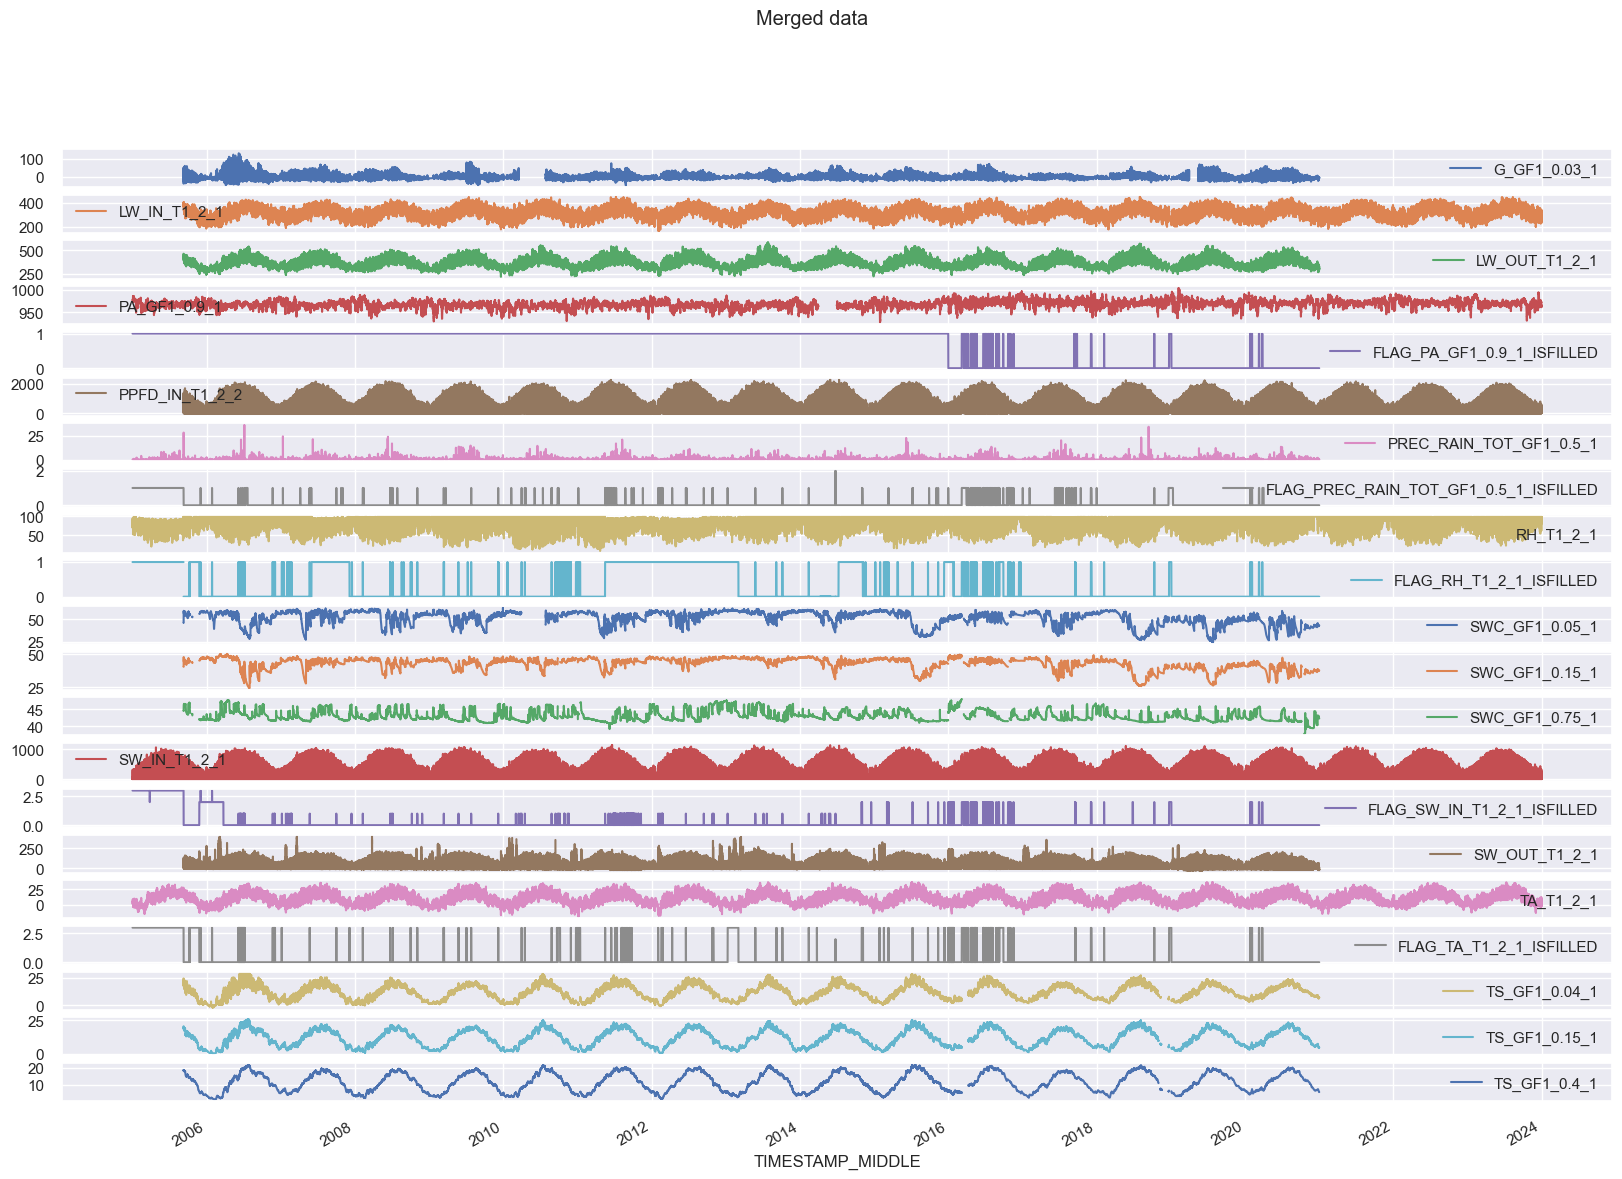

In [16]:
data_simple_merged.plot(subplots=True, x_compat=True, title="Merged data", figsize=(20, 14));

# **SAVE TO FILE**

In [18]:
OUTNAME = "15.1_CH-CHA_meteo6_2005-2023"
OUTPATH = r"F:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_cha_fp2024_2005-2023\10_METEO\13_merge_meteo_for_analyses_2005-2023"
filepath = save_parquet(filename=OUTNAME, data=data_simple_merged, outpath=OUTPATH)
data_simple_merged.to_csv(Path(OUTPATH) / f"{OUTNAME}.csv")

Saved file F:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_cha_fp2024_2005-2023\10_METEO\13_merge_meteo_for_analyses_2005-2023\15.1_CH-CHA_meteo6_2005-2023.parquet (0.360 seconds).


</br>

# **End of notebook**.

In [19]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-09-02 12:51:09
